In [14]:
from pandas import read_csv

# Let's read the close prices of the BTCUSDT and index by the Open time column
df = read_csv("BTCUSDT.csv", parse_dates=["Open time"], index_col=["Open time"])
prices_series = df["Close"]

import warnings
warnings.filterwarnings('ignore')

prices_series = prices_series.dropna().asfreq('D').ffill()

from datetime import datetime

train_data = prices_series.loc[:datetime(2021, 10, 24)]
test_data = prices_series.loc[datetime(2021, 11, 1):]
values_to_forecast = len(test_data)

In [15]:
from sktime.forecasting.base import BaseForecaster  # type: ignore
from sktime.forecasting.compose import (  # type: ignore
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.trend import PolynomialTrendForecaster  # type: ignore
from sktime.transformations.series.detrend import (  # type: ignore
    ConditionalDeseasonalizer,
    Detrender,
)

from sklearn.tree import DecisionTreeRegressor

degree = 1
window_length = 7
sp=7
deseasonal_model="additive"
regressor = DecisionTreeRegressor(random_state=123)

forecaster = TransformedTargetForecaster(
    [
        (
            "conditional_deseasonalise",
            ConditionalDeseasonalizer(model=deseasonal_model, sp=sp),
        ),
        (
            "detrend",
            Detrender(forecaster=PolynomialTrendForecaster(degree=degree)),
        ),
        (
            "forecast",
            make_reduction(
                estimator=regressor,
                scitype="tabular-regressor",
                window_length=window_length,
                strategy="recursive",
            ),
        ),
    ]
)

In [16]:
model = forecaster.fit(train_data, fh=7)

In [17]:
forecasted_data = model.predict(test_data.index)

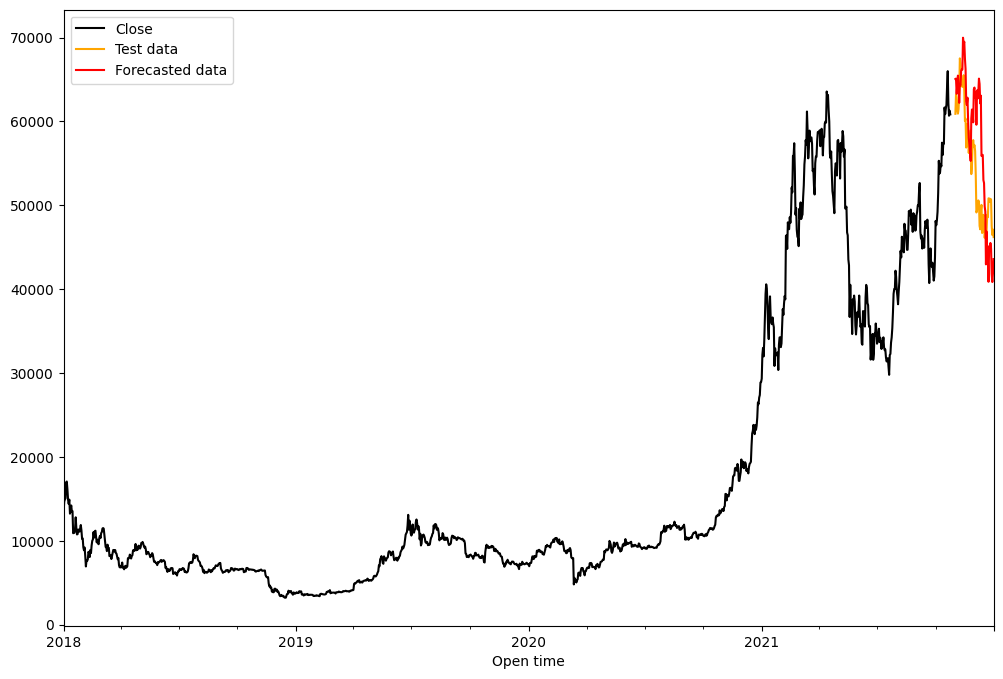

In [18]:
import matplotlib.pyplot as plt

ax = train_data.plot(color='black', figsize=(12, 8), legend=True)

test_data.rename("Test data") \
    .plot(ax=ax, color='orange', figsize=(12, 8), legend=True)

forecasted_data.rename(f"Forecasted data") \
        .plot(ax=ax, color="red", legend=True)

plt.show()